Так как сейчас в индустрии для таких задач как, детекция и сегментация наиболее актуальны билилиотеки от open-mmlab, решил использовать для этой задачи бибилиотеку mmdetection, с целью ее изучения и применения так же на текущем месте работы. 
Для запуска ноутбуков нужно установить бибилиотеку согласно инструкции https://mmsegmentation.readthedocs.io/en/latest/

In [1]:
# подключим свой аккаунт ClearML
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=%%%%%%%%%%%%%%%%%%%%%
%env CLEARML_API_SECRET_KEY=%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [2]:
import mmcv
import mmengine
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import random
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset
from mmengine import Config
from mmengine.runner import Runner
from mmseg.apis import init_model, inference_model, show_result_pyplot
import matplotlib.patches as mpatches

In [3]:
# Зафиксируем random seed
random.seed(142)

In [4]:

def preprocess_mask(mask):
    mask[mask == 2] = 0
    mask[(mask == 1) | (mask == 3.0)] = 1
    return mask

In [58]:
def display_few_examples_from_data(dataset, n=4):
    figure, ax = plt.subplots(nrows=n, ncols=2, figsize=(10, 24))
    for i in range(n):
        im_info = dataset.__getitem__(i)['data_samples']
        image = plt.imread(im_info.img_path)
        mask = plt.imread(im_info.seg_map_path)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

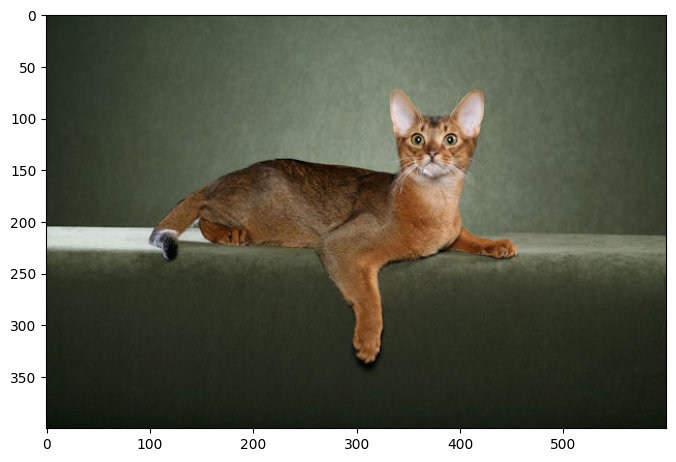

In [5]:
# посмотрим на датасет
img = mmcv.imread('./data/pets/images/Abyssinian_1.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [6]:
# определим путь к датасету и папкам аннотаций и изображений
data_root = './data/pets/'
img_dir = 'images'
ann_dir = 'annotations/labels'
# определим классы и их цвета
classes = ('__background', 'pets')
palette = [[0, 0, 0], [128, 128, 128]]

In [11]:
# конвертируем аннотации в формат semantic segmentation map
for file in mmengine.scandir(os.path.join(data_root, ann_dir.replace('labels', 'trimaps'))):
    
  seg_map = np.array(Image.open(os.path.join(data_root, ann_dir, file))).astype(np.uint8)
  seg_map = preprocess_mask(seg_map)
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(os.path.join(data_root, ann_dir, file))

/tmp/ipykernel_944/2033268633.py:11: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,


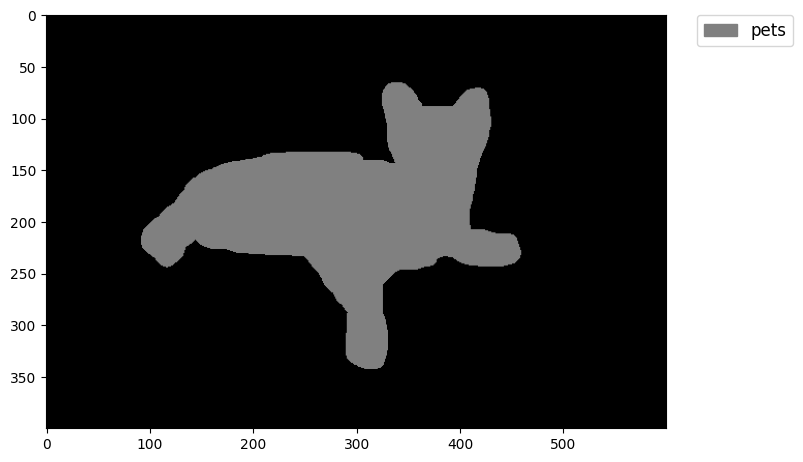

In [13]:
# посмотрим на аннотации
img = Image.open('./data/pets/annotations/labels/Abyssinian_1.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]

plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [17]:
# разделим тренировочную и тестовую выборки
split_dir = 'splits'
mmengine.mkdir_or_exist(os.path.join(data_root, split_dir))
filename_list = [os.path.splitext(filename)[0] for filename in mmengine.scandir(
    os.path.join(data_root, ann_dir), suffix='.png')]
random.shuffle(filename_list)
with open(os.path.join(data_root, split_dir, 'train.txt'), 'w') as f:

  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(os.path.join(data_root, split_dir, 'val.txt'), 'w') as f:

  f.writelines(line + '\n' for line in filename_list[train_length:])

In [7]:
# создадим класс нашего датасета
@DATASETS.register_module()
class PetDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', **kwargs)

In [8]:
# загрузим конфиг файл предобученной модели, предоставляемой бибилиотекой mmsegmentations
cfg = Config.fromfile('./checkpoints/fcn_r18-d8_4xb2-80k_cityscapes-512x1024.py')

In [9]:
# изменим конфиг под нашу задачу
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (512, 512)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

cfg.dataset_type = 'PetDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 8

# пропишем аугментации
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(640, 480), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(640, 480), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader


# добавим веса предобученной модели
cfg.load_from = './checkpoints/fcn_r18-d8_512x1024_80k_cityscapes_20201225_021327-6c50f8b4.pth'

cfg.work_dir = './work_dirs/fcn'

cfg.train_cfg.val_interval = 800
cfg.default_hooks.logger.interval = 50
cfg.default_hooks.checkpoint.interval = 800

cfg.visualizer = dict(
    name='visualizer',
    type='SegLocalVisualizer',
    vis_backends=[
        dict(type='LocalVisBackend'),
        dict(type='ClearMLVisBackend')
    ])

cfg['randomness'] = dict(seed=142)

In [10]:
# создадим раннер для обучения
runner = Runner.from_cfg(cfg)

01/22 19:21:22 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.18 (main, Sep 11 2023, 13:41:44) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 142
    GPU 0: NVIDIA GeForce RTX 2060 SUPER
    CUDA_HOME: /usr
    NVCC: Cuda compilation tools, release 11.5, V11.5.119
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencod

Retrying (Retry(total=239, connect=239, read=240, redirect=240, status=240)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fea9e4bb580>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution')': /auth.login
Retrying (Retry(total=238, connect=238, read=240, redirect=240, status=240)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fea9e0c2460>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution')': /auth.login
Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fea9e0d14c0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution')': /auth.login


ClearML Task: created new task id=a93188b855174da282979ea18b417368
ClearML results page: https://app.clear.ml/projects/fd5ac3e40e62492abbe21ad2dcb781f5/experiments/a93188b855174da282979ea18b417368/output/log
2024-01-22 19:22:19,032 - clearml.Task - INFO - Storing jupyter notebook directly as code


/home/eugene/ML_Courses/CV/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning:


/home/eugene/ML_Courses/CV/mmsegmentation/mmseg/models/decode_heads/decode_head.py:120: UserWarning:

For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold

/home/eugene/ML_Courses/CV/mmsegmentation/mmseg/models/builder.py:36: UserWarning:

``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 

/home/eugene/ML_Courses/CV/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning:

Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.



01/22 19:22:21 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
01/22 19:22:21 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/home/eugene/ML_Courses/CV/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:60: UserWarning:

The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.



ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


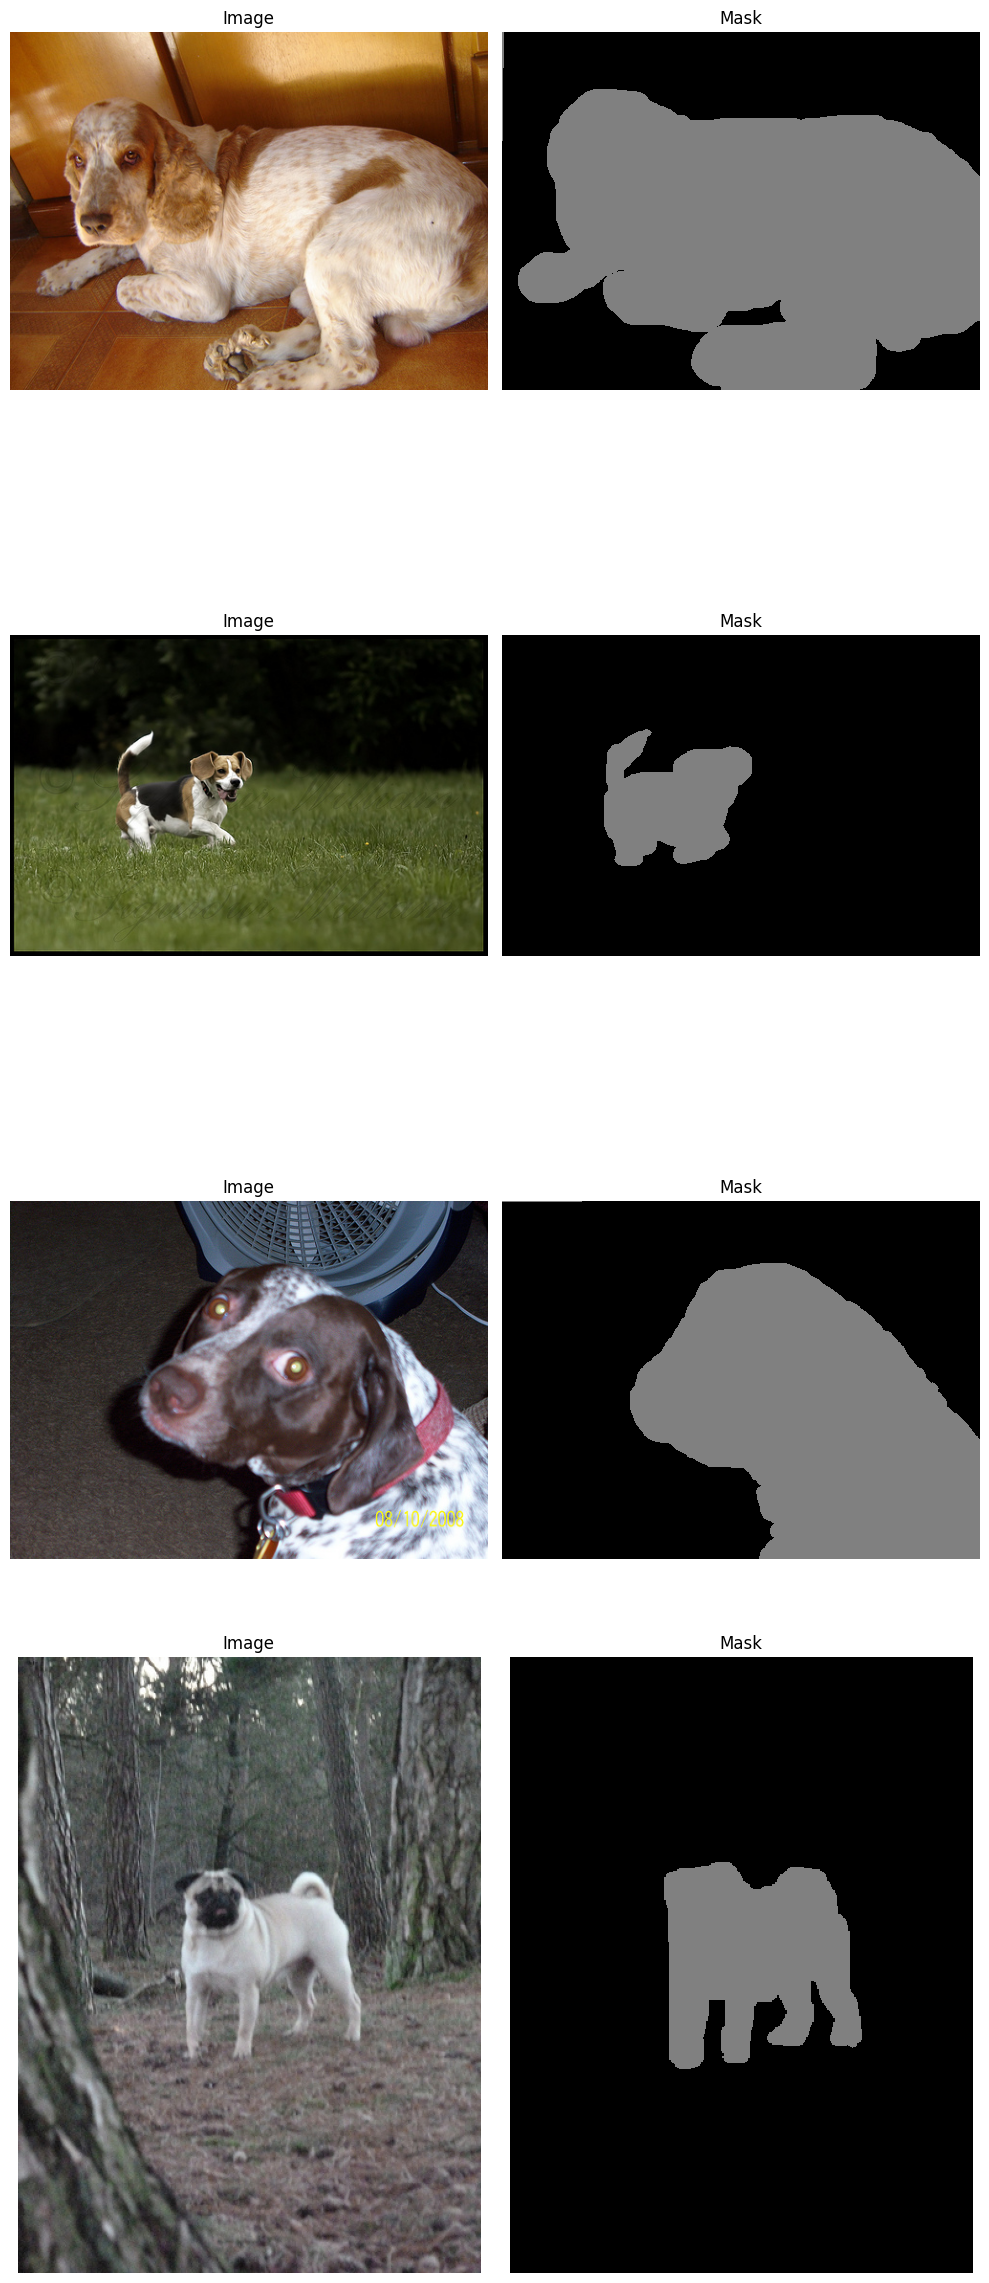

Validation dataset
01/22 20:23:01 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.


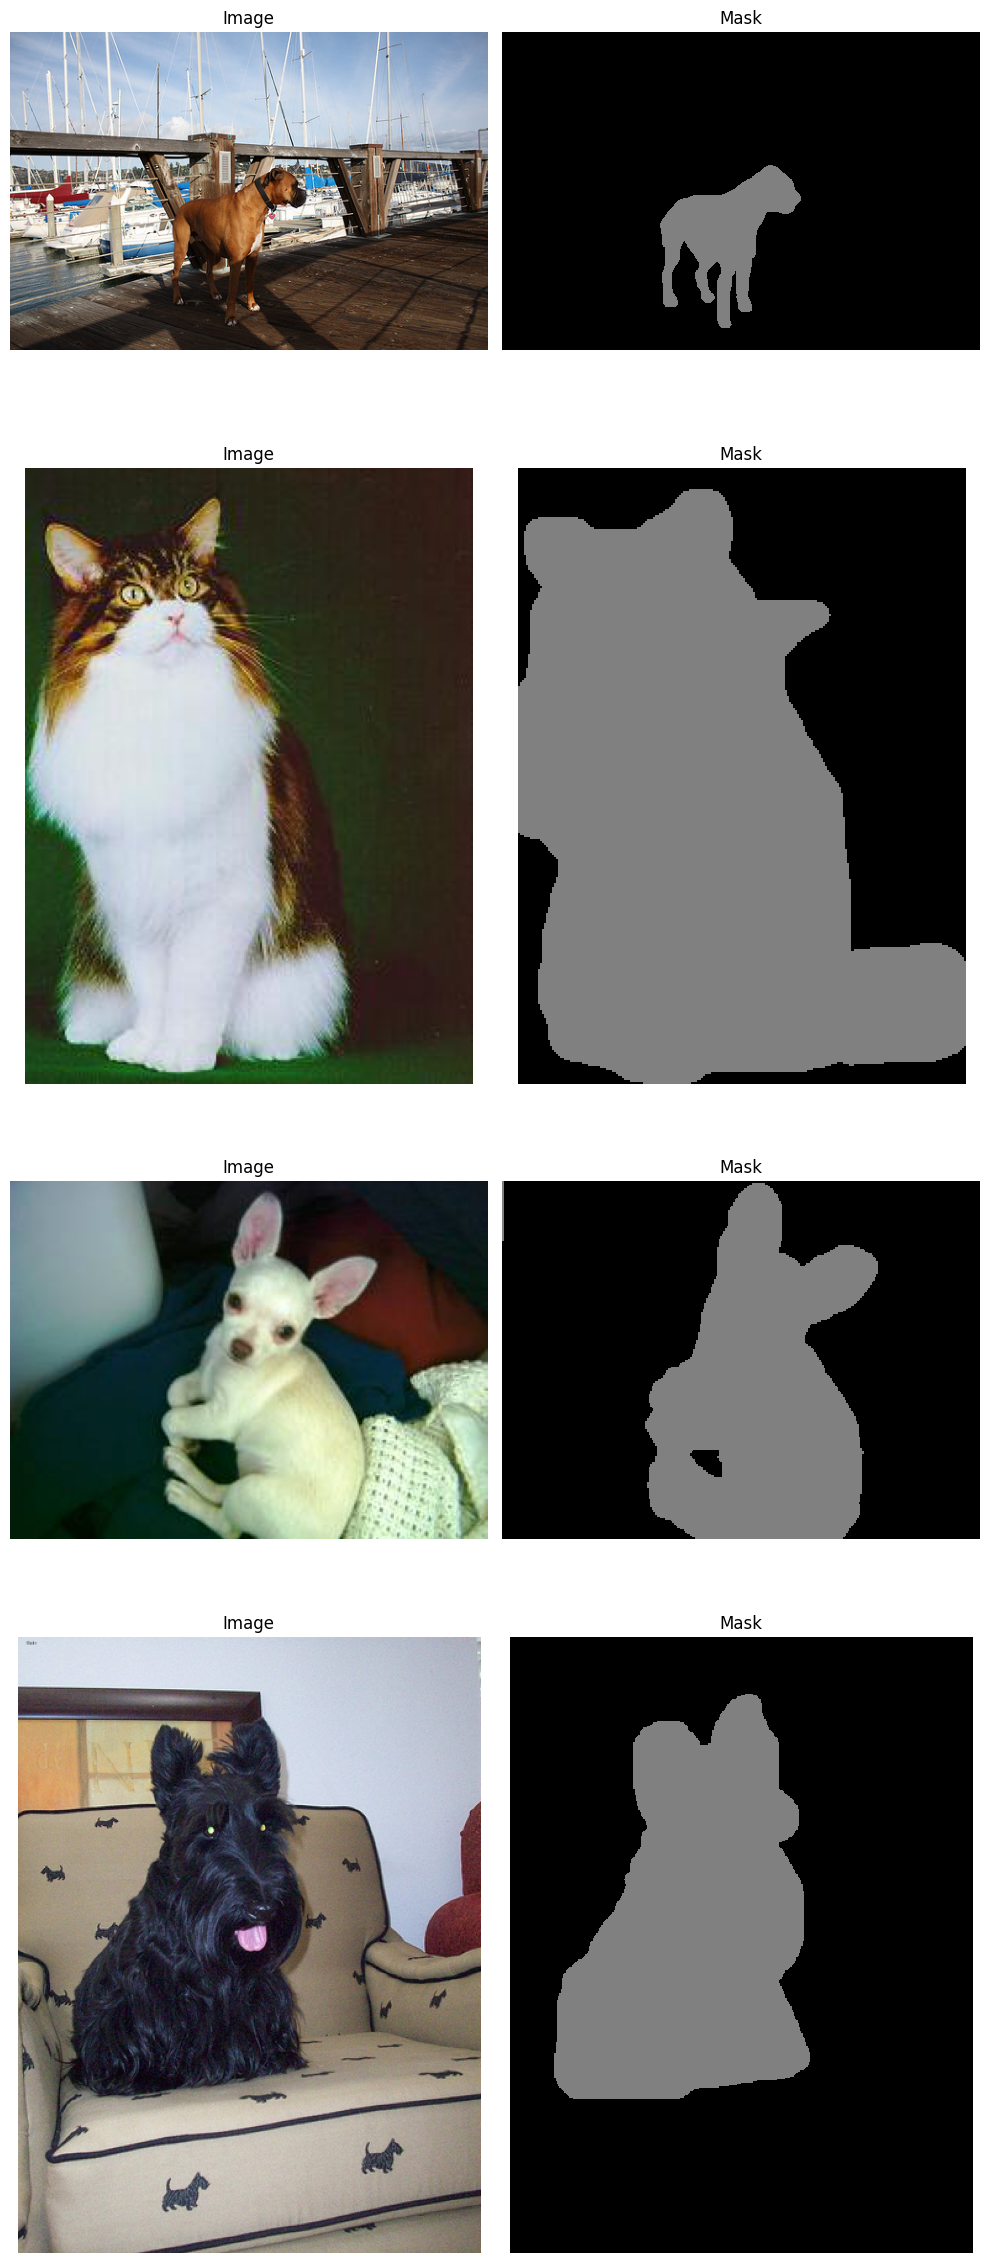

In [60]:
# посомтрим на несколько экземпляров из получившихся датасетов
display_few_examples_from_data(runner.train_dataloader.dataset)
print("Validation dataset")
display_few_examples_from_data(runner.val_dataloader.dataset)

In [26]:
# обучим модель
runner.train()

01/21 23:37:49 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
01/21 23:37:49 - mmengine - INFO - load model from: open-mmlab://resnet18_v1c
01/21 23:37:49 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnet18_v1c
01/21 23:38:02 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

Loads checkpoint by local backend from path: ./checkpoints/fcn_r18-d8_512x1024_80k_cityscapes_20201225_021327-6c50f8b4.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 128, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param wit

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


01/21 23:40:32 - mmengine - INFO - Iter(train) [  300/80000]  lr: 9.9667e-03  eta: 10:31:38  time: 0.4257  data_time: 0.0068  memory: 2729  loss: 0.4051  decode.loss_ce: 0.2776  decode.acc_seg: 83.6351  aux.loss_ce: 0.1274  aux.acc_seg: 80.9236
01/21 23:40:54 - mmengine - INFO - Iter(train) [  350/80000]  lr: 9.9611e-03  eta: 10:21:47  time: 0.4259  data_time: 0.0069  memory: 2728  loss: 0.3578  decode.loss_ce: 0.2425  decode.acc_seg: 91.6658  aux.loss_ce: 0.1153  aux.acc_seg: 87.9128
01/21 23:41:15 - mmengine - INFO - Iter(train) [  400/80000]  lr: 9.9555e-03  eta: 10:13:58  time: 0.4222  data_time: 0.0068  memory: 2728  loss: 0.4382  decode.loss_ce: 0.3002  decode.acc_seg: 74.9729  aux.loss_ce: 0.1379  aux.acc_seg: 69.9410


Corrupt JPEG data: premature end of data segment


01/21 23:41:36 - mmengine - INFO - Iter(train) [  450/80000]  lr: 9.9500e-03  eta: 10:07:49  time: 0.4259  data_time: 0.0069  memory: 2728  loss: 0.4028  decode.loss_ce: 0.2766  decode.acc_seg: 88.0676  aux.loss_ce: 0.1262  aux.acc_seg: 88.3516
01/21 23:41:57 - mmengine - INFO - Iter(train) [  500/80000]  lr: 9.9444e-03  eta: 10:02:50  time: 0.4223  data_time: 0.0068  memory: 2729  loss: 0.4037  decode.loss_ce: 0.2711  decode.acc_seg: 86.5265  aux.loss_ce: 0.1325  aux.acc_seg: 85.5477
01/21 23:42:18 - mmengine - INFO - Iter(train) [  550/80000]  lr: 9.9388e-03  eta: 9:59:06  time: 0.4264  data_time: 0.0069  memory: 2729  loss: 0.4090  decode.loss_ce: 0.2798  decode.acc_seg: 93.6813  aux.loss_ce: 0.1292  aux.acc_seg: 91.1650
01/21 23:42:40 - mmengine - INFO - Iter(train) [  600/80000]  lr: 9.9333e-03  eta: 9:55:49  time: 0.4256  data_time: 0.0069  memory: 2729  loss: 0.2837  decode.loss_ce: 0.1881  decode.acc_seg: 88.7807  aux.loss_ce: 0.0956  aux.acc_seg: 84.1470
01/21 23:43:01 - mmeng

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


01/21 23:43:44 - mmengine - INFO - Iter(train) [  750/80000]  lr: 9.9165e-03  eta: 9:47:59  time: 0.4263  data_time: 0.0071  memory: 2730  loss: 0.3719  decode.loss_ce: 0.2486  decode.acc_seg: 90.8872  aux.loss_ce: 0.1233  aux.acc_seg: 87.1102
01/21 23:44:05 - mmengine - INFO - Iter(train) [  800/80000]  lr: 9.9110e-03  eta: 9:45:51  time: 0.4218  data_time: 0.0071  memory: 2729  loss: 0.3359  decode.loss_ce: 0.2258  decode.acc_seg: 95.6030  aux.loss_ce: 0.1100  aux.acc_seg: 94.0030
01/21 23:44:05 - mmengine - INFO - Saving checkpoint at 800 iterations
01/21 23:44:21 - mmengine - INFO - Iter(val) [  50/1477]    eta: 0:07:32  time: 0.2850  data_time: 0.0014  memory: 4360  
01/21 23:44:29 - mmengine - INFO - Iter(val) [ 100/1477]    eta: 0:05:33  time: 0.0222  data_time: 0.0015  memory: 4361  
01/21 23:44:33 - mmengine - INFO - Iter(val) [ 150/1477]    eta: 0:04:09  time: 0.0432  data_time: 0.0014  memory: 4359  
01/21 23:44:45 - mmengine - INFO - Iter(val) [ 200/1477]    eta: 0:04:17  t

Corrupt JPEG data: premature end of data segment


01/21 23:48:44 - mmengine - INFO - Iter(train) [ 1200/80000]  lr: 9.8664e-03  eta: 9:35:03  time: 0.4228  data_time: 0.0071  memory: 2729  loss: 0.3011  decode.loss_ce: 0.1985  decode.acc_seg: 92.9951  aux.loss_ce: 0.1026  aux.acc_seg: 90.2101
01/21 23:49:06 - mmengine - INFO - Iter(train) [ 1250/80000]  lr: 9.8608e-03  eta: 9:34:00  time: 0.4225  data_time: 0.0074  memory: 2729  loss: 0.3488  decode.loss_ce: 0.2366  decode.acc_seg: 92.0368  aux.loss_ce: 0.1121  aux.acc_seg: 90.5981
01/21 23:49:27 - mmengine - INFO - Iter(train) [ 1300/80000]  lr: 9.8552e-03  eta: 9:32:53  time: 0.4219  data_time: 0.0069  memory: 2729  loss: 0.2854  decode.loss_ce: 0.1900  decode.acc_seg: 88.1786  aux.loss_ce: 0.0954  aux.acc_seg: 84.3438
01/21 23:49:48 - mmengine - INFO - Iter(train) [ 1350/80000]  lr: 9.8496e-03  eta: 9:31:56  time: 0.4265  data_time: 0.0071  memory: 2729  loss: 0.2974  decode.loss_ce: 0.1987  decode.acc_seg: 86.7969  aux.loss_ce: 0.0987  aux.acc_seg: 81.3798
01/21 23:50:09 - mmengin

Corrupt JPEG data: premature end of data segment


01/21 23:54:35 - mmengine - INFO - Iter(train) [ 1950/80000]  lr: 9.7827e-03  eta: 9:23:21  time: 0.4269  data_time: 0.0073  memory: 2729  loss: 0.3281  decode.loss_ce: 0.2205  decode.acc_seg: 91.9047  aux.loss_ce: 0.1077  aux.acc_seg: 87.2886
01/21 23:54:56 - mmengine - INFO - Exp name: fcn_r18-d8_4xb2-80k_cityscapes-512x1024_20240121_233725
01/21 23:54:56 - mmengine - INFO - Iter(train) [ 2000/80000]  lr: 9.7771e-03  eta: 9:22:47  time: 0.4224  data_time: 0.0073  memory: 2729  loss: 0.2393  decode.loss_ce: 0.1566  decode.acc_seg: 94.6312  aux.loss_ce: 0.0828  aux.acc_seg: 90.2551


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


01/21 23:55:18 - mmengine - INFO - Iter(train) [ 2050/80000]  lr: 9.7715e-03  eta: 9:22:12  time: 0.4262  data_time: 0.0071  memory: 2729  loss: 0.2874  decode.loss_ce: 0.1914  decode.acc_seg: 89.8384  aux.loss_ce: 0.0959  aux.acc_seg: 88.5088
01/21 23:55:39 - mmengine - INFO - Iter(train) [ 2100/80000]  lr: 9.7659e-03  eta: 9:21:39  time: 0.4263  data_time: 0.0077  memory: 2729  loss: 0.3276  decode.loss_ce: 0.2234  decode.acc_seg: 81.8629  aux.loss_ce: 0.1042  aux.acc_seg: 81.1014
01/21 23:56:00 - mmengine - INFO - Iter(train) [ 2150/80000]  lr: 9.7603e-03  eta: 9:21:06  time: 0.4260  data_time: 0.0071  memory: 2728  loss: 0.2488  decode.loss_ce: 0.1636  decode.acc_seg: 92.9033  aux.loss_ce: 0.0852  aux.acc_seg: 90.1099
01/21 23:56:22 - mmengine - INFO - Iter(train) [ 2200/80000]  lr: 9.7547e-03  eta: 9:20:35  time: 0.4270  data_time: 0.0072  memory: 2728  loss: 0.2709  decode.loss_ce: 0.1779  decode.acc_seg: 95.9191  aux.loss_ce: 0.0930  aux.acc_seg: 92.3454
01/21 23:56:43 - mmengin

Corrupt JPEG data: premature end of data segment


01/21 23:57:47 - mmengine - INFO - Iter(train) [ 2400/80000]  lr: 9.7324e-03  eta: 9:18:25  time: 0.4228  data_time: 0.0071  memory: 2729  loss: 0.2595  decode.loss_ce: 0.1706  decode.acc_seg: 88.1658  aux.loss_ce: 0.0889  aux.acc_seg: 84.4242
01/21 23:57:47 - mmengine - INFO - Saving checkpoint at 2400 iterations
01/21 23:57:48 - mmengine - INFO - Iter(val) [  50/1477]    eta: 0:00:30  time: 0.0210  data_time: 0.0013  memory: 262  
01/21 23:57:49 - mmengine - INFO - Iter(val) [ 100/1477]    eta: 0:00:29  time: 0.0216  data_time: 0.0013  memory: 266  
01/21 23:57:50 - mmengine - INFO - Iter(val) [ 150/1477]    eta: 0:00:28  time: 0.0212  data_time: 0.0012  memory: 262  
01/21 23:57:51 - mmengine - INFO - Iter(val) [ 200/1477]    eta: 0:00:27  time: 0.0212  data_time: 0.0013  memory: 262  
01/21 23:57:52 - mmengine - INFO - Iter(val) [ 250/1477]    eta: 0:00:25  time: 0.0208  data_time: 0.0012  memory: 262  
01/21 23:57:53 - mmengine - INFO - Iter(val) [ 300/1477]    eta: 0:00:24  time:

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


01/22 00:00:26 - mmengine - INFO - Iter(train) [ 2700/80000]  lr: 9.6989e-03  eta: 9:15:13  time: 0.4252  data_time: 0.0072  memory: 2729  loss: 0.2472  decode.loss_ce: 0.1613  decode.acc_seg: 94.9259  aux.loss_ce: 0.0859  aux.acc_seg: 92.3141
01/22 00:00:47 - mmengine - INFO - Iter(train) [ 2750/80000]  lr: 9.6933e-03  eta: 9:14:44  time: 0.4260  data_time: 0.0072  memory: 2729  loss: 0.2749  decode.loss_ce: 0.1849  decode.acc_seg: 88.4708  aux.loss_ce: 0.0900  aux.acc_seg: 85.3987
01/22 00:01:08 - mmengine - INFO - Iter(train) [ 2800/80000]  lr: 9.6877e-03  eta: 9:14:16  time: 0.4252  data_time: 0.0070  memory: 2729  loss: 0.2865  decode.loss_ce: 0.1901  decode.acc_seg: 91.7165  aux.loss_ce: 0.0965  aux.acc_seg: 87.0991
01/22 00:01:29 - mmengine - INFO - Iter(train) [ 2850/80000]  lr: 9.6821e-03  eta: 9:13:48  time: 0.4265  data_time: 0.0073  memory: 2729  loss: 0.2221  decode.loss_ce: 0.1443  decode.acc_seg: 94.8095  aux.loss_ce: 0.0778  aux.acc_seg: 92.5406
01/22 00:01:51 - mmengin

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


01/22 00:04:51 - mmengine - INFO - Iter(train) [ 3250/80000]  lr: 9.6374e-03  eta: 9:10:02  time: 0.4247  data_time: 0.0072  memory: 2729  loss: 0.2715  decode.loss_ce: 0.1763  decode.acc_seg: 90.5233  aux.loss_ce: 0.0951  aux.acc_seg: 89.2650
01/22 00:05:12 - mmengine - INFO - Iter(train) [ 3300/80000]  lr: 9.6318e-03  eta: 9:09:34  time: 0.4228  data_time: 0.0072  memory: 2729  loss: 0.2826  decode.loss_ce: 0.1889  decode.acc_seg: 90.5373  aux.loss_ce: 0.0938  aux.acc_seg: 88.9243
01/22 00:05:33 - mmengine - INFO - Iter(train) [ 3350/80000]  lr: 9.6262e-03  eta: 9:09:04  time: 0.4224  data_time: 0.0073  memory: 2729  loss: 0.2239  decode.loss_ce: 0.1475  decode.acc_seg: 88.4212  aux.loss_ce: 0.0764  aux.acc_seg: 85.4473


Corrupt JPEG data: premature end of data segment


01/22 00:05:55 - mmengine - INFO - Iter(train) [ 3400/80000]  lr: 9.6206e-03  eta: 9:08:37  time: 0.4272  data_time: 0.0071  memory: 2729  loss: 0.2531  decode.loss_ce: 0.1669  decode.acc_seg: 86.6652  aux.loss_ce: 0.0862  aux.acc_seg: 83.9817
01/22 00:06:16 - mmengine - INFO - Iter(train) [ 3450/80000]  lr: 9.6150e-03  eta: 9:08:15  time: 0.4273  data_time: 0.0073  memory: 2729  loss: 0.2243  decode.loss_ce: 0.1493  decode.acc_seg: 83.8123  aux.loss_ce: 0.0750  aux.acc_seg: 82.3021
01/22 00:06:37 - mmengine - INFO - Iter(train) [ 3500/80000]  lr: 9.6094e-03  eta: 9:07:50  time: 0.4263  data_time: 0.0072  memory: 2728  loss: 0.3211  decode.loss_ce: 0.2156  decode.acc_seg: 93.1155  aux.loss_ce: 0.1055  aux.acc_seg: 88.2404
01/22 00:06:59 - mmengine - INFO - Iter(train) [ 3550/80000]  lr: 9.6038e-03  eta: 9:07:26  time: 0.4272  data_time: 0.0073  memory: 2729  loss: 0.2308  decode.loss_ce: 0.1521  decode.acc_seg: 87.0137  aux.loss_ce: 0.0787  aux.acc_seg: 84.4414
01/22 00:07:20 - mmengin

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


01/22 00:08:45 - mmengine - INFO - Iter(train) [ 3800/80000]  lr: 9.5759e-03  eta: 9:05:18  time: 0.4258  data_time: 0.0073  memory: 2730  loss: 0.2623  decode.loss_ce: 0.1713  decode.acc_seg: 95.2081  aux.loss_ce: 0.0910  aux.acc_seg: 91.9644
01/22 00:09:06 - mmengine - INFO - Iter(train) [ 3850/80000]  lr: 9.5703e-03  eta: 9:04:54  time: 0.4262  data_time: 0.0072  memory: 2729  loss: 0.2743  decode.loss_ce: 0.1823  decode.acc_seg: 92.5295  aux.loss_ce: 0.0920  aux.acc_seg: 87.7377
01/22 00:09:28 - mmengine - INFO - Iter(train) [ 3900/80000]  lr: 9.5647e-03  eta: 9:04:31  time: 0.4280  data_time: 0.0074  memory: 2729  loss: 0.2374  decode.loss_ce: 0.1520  decode.acc_seg: 92.2549  aux.loss_ce: 0.0854  aux.acc_seg: 87.8404
01/22 00:09:49 - mmengine - INFO - Iter(train) [ 3950/80000]  lr: 9.5591e-03  eta: 9:04:09  time: 0.4256  data_time: 0.0072  memory: 2729  loss: 0.2639  decode.loss_ce: 0.1719  decode.acc_seg: 84.3466  aux.loss_ce: 0.0919  aux.acc_seg: 83.8424
01/22 00:10:11 - mmengin

Corrupt JPEG data: premature end of data segment


01/22 00:13:32 - mmengine - INFO - Iter(train) [ 4400/80000]  lr: 9.5087e-03  eta: 9:00:26  time: 0.4222  data_time: 0.0074  memory: 2729  loss: 0.2923  decode.loss_ce: 0.1957  decode.acc_seg: 86.7844  aux.loss_ce: 0.0966  aux.acc_seg: 83.4426
01/22 00:13:54 - mmengine - INFO - Iter(train) [ 4450/80000]  lr: 9.5031e-03  eta: 9:00:03  time: 0.4221  data_time: 0.0075  memory: 2729  loss: 0.2501  decode.loss_ce: 0.1600  decode.acc_seg: 93.2270  aux.loss_ce: 0.0901  aux.acc_seg: 89.4407
01/22 00:14:15 - mmengine - INFO - Iter(train) [ 4500/80000]  lr: 9.4975e-03  eta: 8:59:36  time: 0.4224  data_time: 0.0076  memory: 2729  loss: 0.2548  decode.loss_ce: 0.1631  decode.acc_seg: 89.7270  aux.loss_ce: 0.0916  aux.acc_seg: 85.5396
01/22 00:14:36 - mmengine - INFO - Iter(train) [ 4550/80000]  lr: 9.4919e-03  eta: 8:59:12  time: 0.4261  data_time: 0.0074  memory: 2728  loss: 0.2298  decode.loss_ce: 0.1492  decode.acc_seg: 95.7743  aux.loss_ce: 0.0805  aux.acc_seg: 93.5805
01/22 00:14:57 - mmengin

Corrupt JPEG data: premature end of data segment


01/22 00:15:40 - mmengine - INFO - Iter(train) [ 4700/80000]  lr: 9.4751e-03  eta: 8:58:00  time: 0.4239  data_time: 0.0072  memory: 2729  loss: 0.2256  decode.loss_ce: 0.1462  decode.acc_seg: 87.2434  aux.loss_ce: 0.0794  aux.acc_seg: 86.4044
01/22 00:16:01 - mmengine - INFO - Iter(train) [ 4750/80000]  lr: 9.4695e-03  eta: 8:57:35  time: 0.4217  data_time: 0.0073  memory: 2729  loss: 0.2301  decode.loss_ce: 0.1519  decode.acc_seg: 96.5935  aux.loss_ce: 0.0782  aux.acc_seg: 93.8510
01/22 00:16:22 - mmengine - INFO - Iter(train) [ 4800/80000]  lr: 9.4639e-03  eta: 8:57:09  time: 0.4219  data_time: 0.0072  memory: 2729  loss: 0.2772  decode.loss_ce: 0.1808  decode.acc_seg: 94.3526  aux.loss_ce: 0.0964  aux.acc_seg: 91.4376
01/22 00:16:22 - mmengine - INFO - Saving checkpoint at 4800 iterations
01/22 00:16:24 - mmengine - INFO - Iter(val) [  50/1477]    eta: 0:00:30  time: 0.0212  data_time: 0.0015  memory: 262  
01/22 00:16:25 - mmengine - INFO - Iter(val) [ 100/1477]    eta: 0:00:29  t

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


01/22 00:17:36 - mmengine - INFO - Iter(train) [ 4900/80000]  lr: 9.4527e-03  eta: 8:56:25  time: 0.4273  data_time: 0.0079  memory: 2729  loss: 0.2288  decode.loss_ce: 0.1505  decode.acc_seg: 88.6207  aux.loss_ce: 0.0782  aux.acc_seg: 84.8073
01/22 00:17:58 - mmengine - INFO - Iter(train) [ 4950/80000]  lr: 9.4471e-03  eta: 8:56:01  time: 0.4259  data_time: 0.0073  memory: 2729  loss: 0.2277  decode.loss_ce: 0.1431  decode.acc_seg: 94.7832  aux.loss_ce: 0.0846  aux.acc_seg: 92.4524
01/22 00:18:19 - mmengine - INFO - Exp name: fcn_r18-d8_4xb2-80k_cityscapes-512x1024_20240121_233725
01/22 00:18:19 - mmengine - INFO - Iter(train) [ 5000/80000]  lr: 9.4414e-03  eta: 8:55:38  time: 0.4262  data_time: 0.0072  memory: 2729  loss: 0.2736  decode.loss_ce: 0.1778  decode.acc_seg: 92.0419  aux.loss_ce: 0.0958  aux.acc_seg: 89.0010
01/22 00:18:40 - mmengine - INFO - Iter(train) [ 5050/80000]  lr: 9.4358e-03  eta: 8:55:14  time: 0.4231  data_time: 0.0071  memory: 2729  loss: 0.2059  decode.loss_ce

Corrupt JPEG data: premature end of data segment


01/22 00:20:26 - mmengine - INFO - Iter(train) [ 5300/80000]  lr: 9.4078e-03  eta: 8:53:13  time: 0.4261  data_time: 0.0072  memory: 2729  loss: 0.2045  decode.loss_ce: 0.1315  decode.acc_seg: 91.3282  aux.loss_ce: 0.0729  aux.acc_seg: 88.0123
01/22 00:20:48 - mmengine - INFO - Iter(train) [ 5350/80000]  lr: 9.4022e-03  eta: 8:52:49  time: 0.4225  data_time: 0.0073  memory: 2728  loss: 0.2789  decode.loss_ce: 0.1832  decode.acc_seg: 90.6103  aux.loss_ce: 0.0958  aux.acc_seg: 85.3503
01/22 00:21:09 - mmengine - INFO - Iter(train) [ 5400/80000]  lr: 9.3966e-03  eta: 8:52:28  time: 0.4286  data_time: 0.0071  memory: 2729  loss: 0.2342  decode.loss_ce: 0.1535  decode.acc_seg: 94.3656  aux.loss_ce: 0.0807  aux.acc_seg: 92.7144


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


01/22 00:21:31 - mmengine - INFO - Iter(train) [ 5450/80000]  lr: 9.3910e-03  eta: 8:52:06  time: 0.4290  data_time: 0.0078  memory: 2729  loss: 0.1984  decode.loss_ce: 0.1261  decode.acc_seg: 94.7630  aux.loss_ce: 0.0723  aux.acc_seg: 91.0859
01/22 00:21:52 - mmengine - INFO - Iter(train) [ 5500/80000]  lr: 9.3854e-03  eta: 8:51:43  time: 0.4255  data_time: 0.0075  memory: 2729  loss: 0.1966  decode.loss_ce: 0.1267  decode.acc_seg: 89.3639  aux.loss_ce: 0.0699  aux.acc_seg: 88.3143


KeyboardInterrupt: 

Так как метрики модели сильно превысили требуемые в задании, решил остановить обучение вручную

In [73]:
# инициируем модель, загрузим полученные веса
checkpoint_path = './work_dirs/fcn/iter_4800.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

Loads checkpoint by local backend from path: ./work_dirs/fcn/iter_4800.pth


/home/eugene/ML_Courses/CV/mmsegmentation/mmseg/models/decode_heads/decode_head.py:120: UserWarning:

For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold

/home/eugene/ML_Courses/CV/mmsegmentation/mmseg/models/builder.py:36: UserWarning:

``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 

/home/eugene/ML_Courses/CV/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning:

Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.



In [63]:
runner.load_checkpoint('./work_dirs/fcn/iter_4800.pth')

Loads checkpoint by local backend from path: ./work_dirs/fcn/iter_4800.pth
01/22 20:44:50 - mmengine - INFO - Load checkpoint from ./work_dirs/fcn/iter_4800.pth


{'meta': {'epoch': 0,
  'iter': 4800,
  'cfg': "crop_size = (\n    512,\n    512,\n)\ndata_preprocessor = dict(\n    bgr_to_rgb=True,\n    mean=[\n        123.675,\n        116.28,\n        103.53,\n    ],\n    pad_val=0,\n    seg_pad_val=255,\n    size=(\n        512,\n        1024,\n    ),\n    std=[\n        58.395,\n        57.12,\n        57.375,\n    ],\n    type='SegDataPreProcessor')\ndata_root = './data/pets/'\ndataset_type = 'PetDataset'\ndefault_hooks = dict(\n    checkpoint=dict(by_epoch=False, interval=800, type='CheckpointHook'),\n    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),\n    param_scheduler=dict(type='ParamSchedulerHook'),\n    sampler_seed=dict(type='DistSamplerSeedHook'),\n    timer=dict(type='IterTimerHook'),\n    visualization=dict(type='SegVisualizationHook'))\ndefault_scope = 'mmseg'\nenv_cfg = dict(\n    cudnn_benchmark=True,\n    dist_cfg=dict(backend='nccl'),\n    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))\nimg_

In [64]:
runner.val()

01/22 20:45:03 - mmengine - INFO - Iter(val) [  50/1477]    eta: 0:00:39  time: 0.0208  data_time: 0.0014  memory: 1177  
01/22 20:45:04 - mmengine - INFO - Iter(val) [ 100/1477]    eta: 0:00:33  time: 0.0219  data_time: 0.0015  memory: 266  
01/22 20:45:05 - mmengine - INFO - Iter(val) [ 150/1477]    eta: 0:00:31  time: 0.0218  data_time: 0.0014  memory: 259  
01/22 20:45:06 - mmengine - INFO - Iter(val) [ 200/1477]    eta: 0:00:29  time: 0.0219  data_time: 0.0014  memory: 261  
01/22 20:45:07 - mmengine - INFO - Iter(val) [ 250/1477]    eta: 0:00:27  time: 0.0208  data_time: 0.0013  memory: 260  
01/22 20:45:08 - mmengine - INFO - Iter(val) [ 300/1477]    eta: 0:00:26  time: 0.0214  data_time: 0.0013  memory: 259  
01/22 20:45:09 - mmengine - INFO - Iter(val) [ 350/1477]    eta: 0:00:25  time: 0.0206  data_time: 0.0013  memory: 260  
01/22 20:45:10 - mmengine - INFO - Iter(val) [ 400/1477]    eta: 0:00:23  time: 0.0209  data_time: 0.0013  memory: 259  
01/22 20:45:11 - mmengine - INF

Action failed <400/110: tasks.add_or_update_artifacts/v2.10 (Invalid task status: expected=created, status=completed)> (task=a93188b855174da282979ea18b417368, artifacts=[{'key': 'notebook', 'type': 'custom', 'uri': 'https://files.clear.ml/mmsegmentation/mmseg_train.a93188b855174da282979ea18b417368/artifacts/notebook/mmseg_train.ipynb', 'content_size': 656, 'hash': 'e5b6fd98369aec67e9266b067847e71a1a0b759a63d5145cdda7bbca21859dd5', 'timestamp': 1705926142, 'type_data': {'preview': 'See `notebook preview` artifact'}, 'display_data': [('UPDATE', '2024-01-22 12:22:22')]}, {'key': 'notebook preview', 'type': 'custom', 'uri': 'https://files.clear.ml/mmsegmentation/mmseg_train.a93188b855174da282979ea18b417368/artifacts/notebook%20preview/notebook_a93188b855174da282979ea18b417368.html', 'content_size': 269526, 'hash': '1347b5edbffaa750d123adf9f740b458270e5c99f68580f23c4291a23fdd3004', 'timestamp': 1705926145, 'type_data': {'preview': 'Click `FILE PATH` link', 'content_type': 'text/html'}, 'dis

{'aAcc': 92.55, 'mIoU': 85.89, 'mAcc': 93.11}

### mIoU = 85.89

/home/eugene/anaconda3/envs/openmmlab/lib/python3.9/site-packages/mmengine/visualization/visualizer.py:196: UserWarning:

Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.



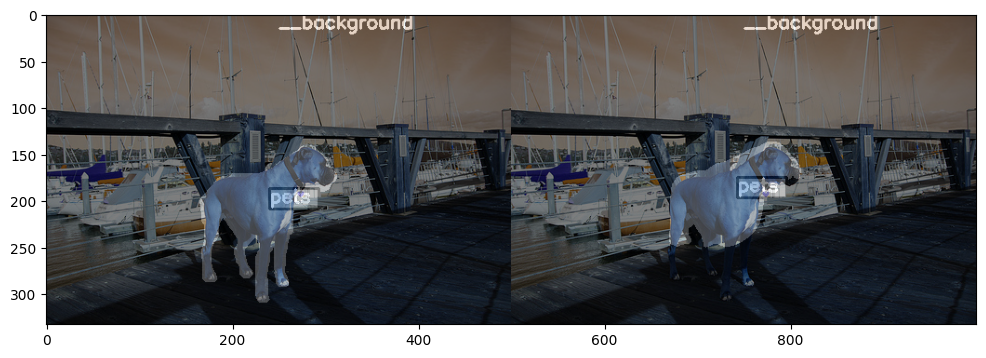

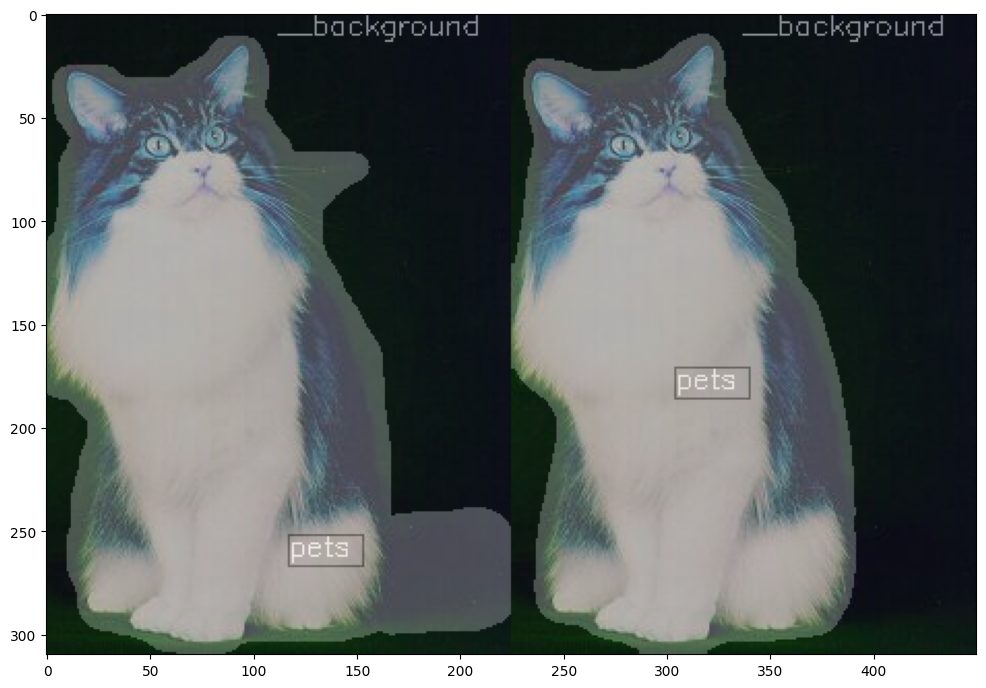

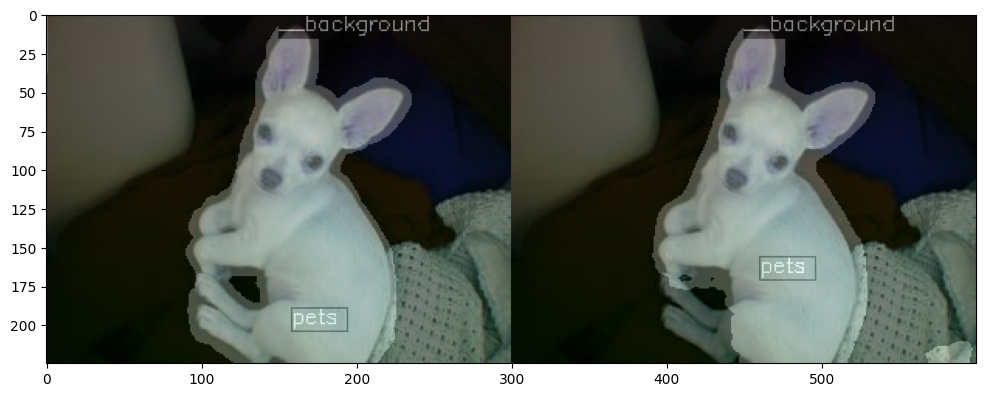

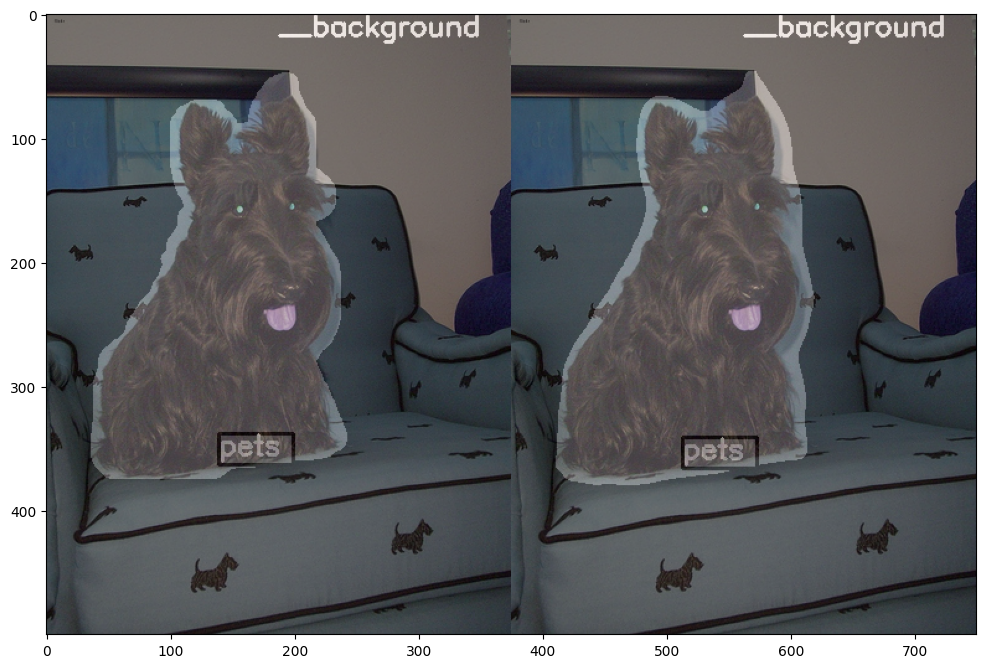

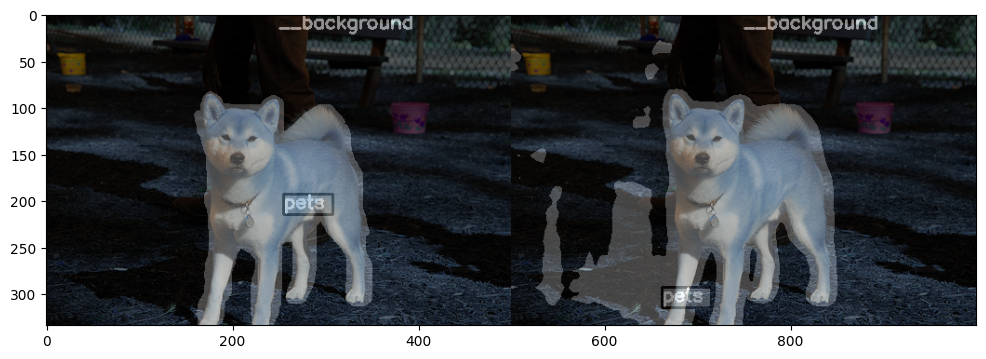

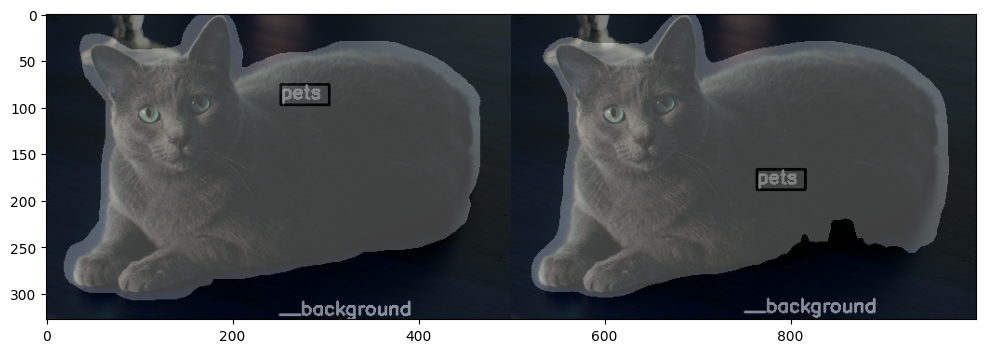

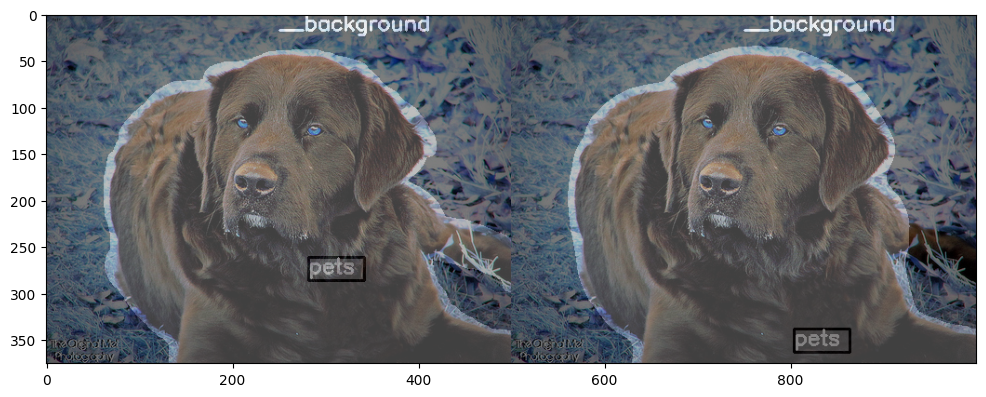

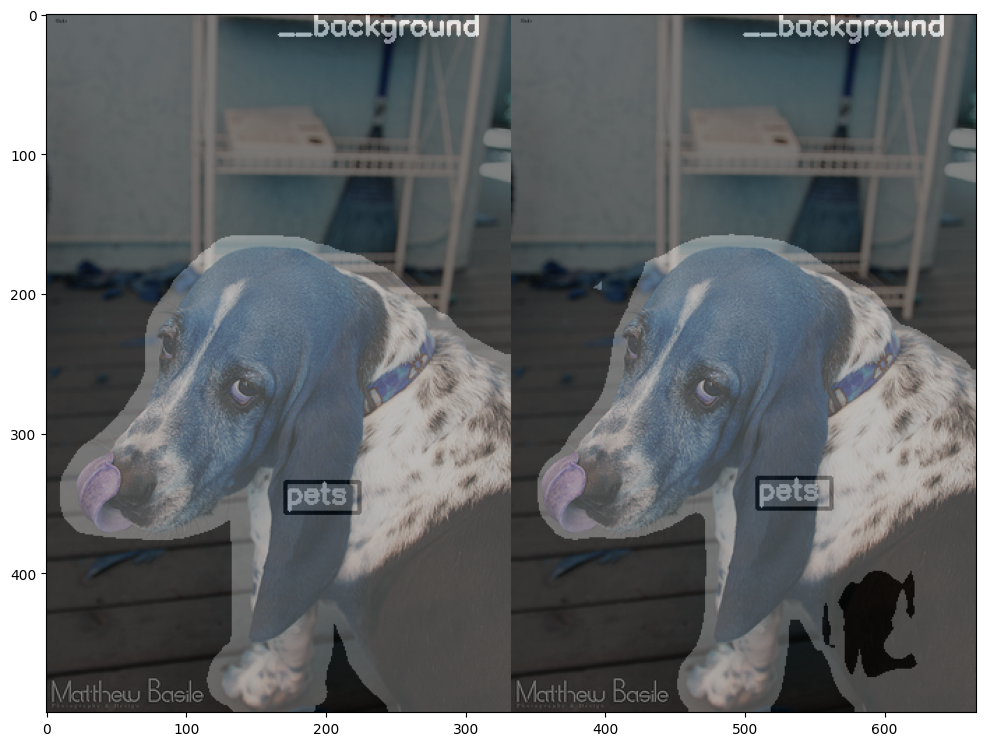

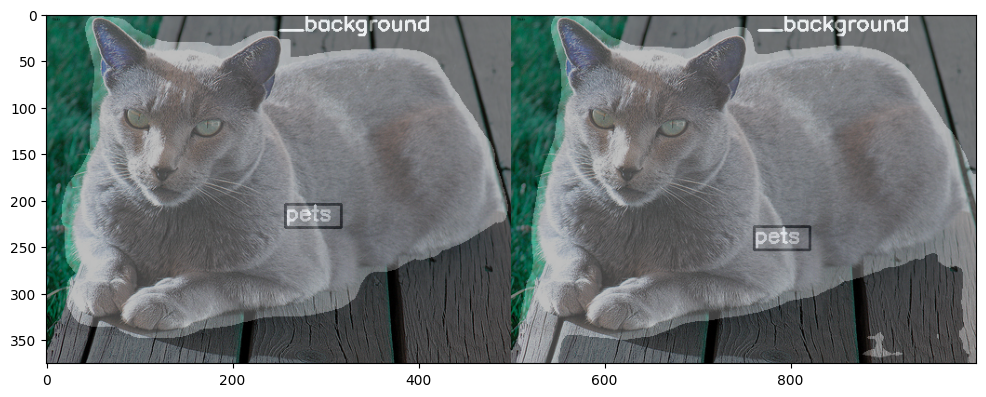

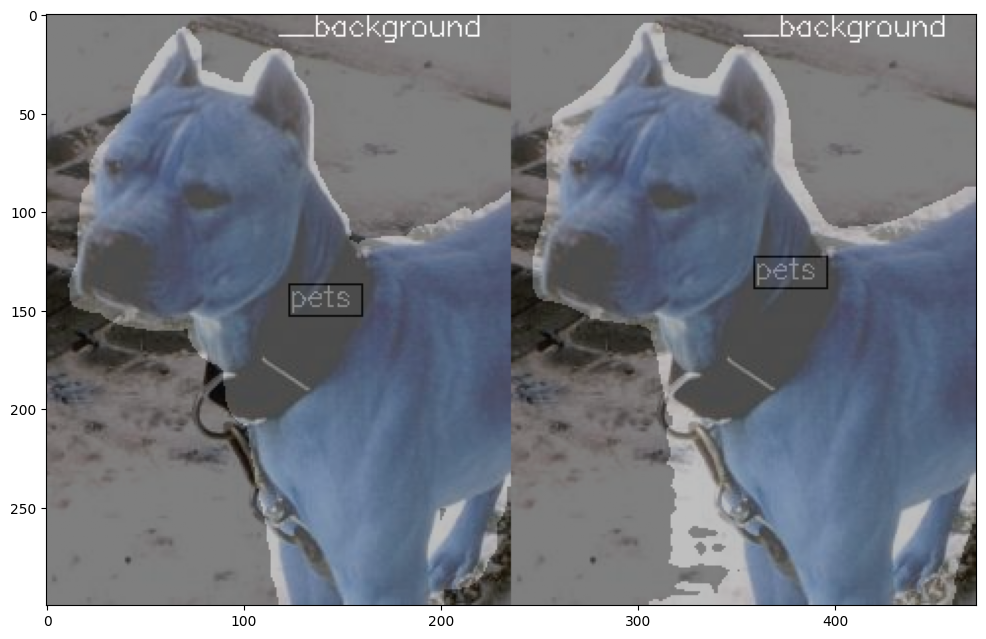

In [119]:
# посомтрим несколько результатов обученной модели и сравним их с размеченными данными
for i in range(10):
    data_sample = runner.val_dataloader.dataset.__getitem__(i)['data_samples']
    im_path = data_sample.img_path
    img = mmcv.imread(im_path)
    result = inference_model(model, img)
    result.gt_sem_seg = data_sample.gt_sem_seg.to('cuda')
    plt.figure(figsize=(12, 10))
    vis_result = show_result_pyplot(model, img, result, out_file='res.png')
    plt.imshow(plt.imread('res.png'))